# **2.1 数据集的准备与介绍

In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
# !ls /home/aistudio/data/HandsOnSteeringWheel/posVOC/
!unzip -oq data/data69849/HandsOnSteeringWheel.zip -d data/HandsOnSteeringWheel
# !tree data/HandsOnSteeringWheel -d

In [ ]:
# 数据集介绍可参考该内容（数据来源、归类领域、数据类型、保存格式、样本数量、类别等具体信息）：
# https://aistudio.baidu.com/aistudio/competition/detail/63/0/task-definition
# 一个方向盘上操作手标注的数据集，只标注了手；
# 类属于交通类的图片数据集
# 数据类型包括.jpg格式的图片数据和VOC格式的标签文件
# 数据集一共有2.8G 5500张图片

5505 5500


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


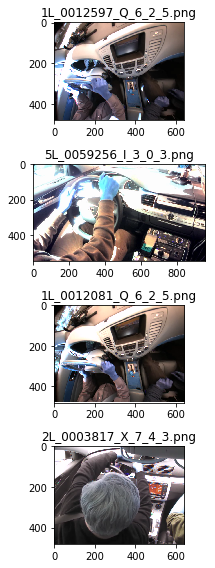

In [ ]:
# 样例：方向盘上操作手标注的数据集抽样可视化
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
img_path = os.path.join('data/HandsOnSteeringWheel/pos')
label_path = os.path.join('data/HandsOnSteeringWheel/posVOC')
image_path_list = os.listdir(img_path)
label_path_list = os.listdir(label_path)
print(len(image_path_list), len(label_path_list))
image_samples_4 = np.random.randint(0, len(image_path_list)-1, size = 4)

plt.figure(figsize=(8, 8))
for i in range(len(image_samples_4)):
    plt.subplot(len(image_samples_4), 2, i*2+1)
    plt.title(image_path_list[image_samples_4[i]])
    img = cv2.imread(os.path.join(img_path,image_path_list[image_samples_4[i]]))
    plt.imshow(img)
plt.tight_layout()
plt.show()


# ***2.2 图像/文本数据的统计分析

In [ ]:
# 计算图像数据整体均值和方差
import glob
import numpy as np


def get_mean_std(image_dir):
    img_path_list = os.listdir(image_dir)
    print('Total images:', len(image_path_list))
    max_val, min_val = np.zeros(3), np.ones(3) * 255
    mean, std = np.zeros(3), np.zeros(3)
    for image_path in image_path_list:
        image = cv2.imread(os.path.join(image_dir,image_path))
        if image is None:
            continue
        for c in range(3):
            mean[c] += image[:, :, c].mean()
            std[c] += image[:, :, c].std()
            max_val[c] = max(max_val[c], image[:, :, c].max())
            min_val[c] = min(min_val[c], image[:, :, c].min())

    mean /= len(image_path_list)
    std /= len(image_path_list)

    mean /= max_val - min_val
    std /= max_val - min_val

    return mean, std
mean, std = get_mean_std('data/HandsOnSteeringWheel/pos/')
print('mean:', mean)
print('std:', std)

Total images: 5500
mean: [0.44014847 0.43202895 0.44313801]
std: [0.32417026 0.32232059 0.31937902]


# ***2.3 数据集类的定义

In [ ]:
# paddle 数据集类的定义（继承paddle.io.Dataset的类）
import paddle
import numpy as np
import paddle.vision.transforms as T


class MyImageNetDataset(paddle.io.Dataset):
    def __init__(self,
                 num_samples,
                 num_classes):
        super(MyImageNetDataset, self).__init__()

        self.num_samples = num_samples
        self.num_classes = num_classes
        self.transform = T.Compose([
            T.Resize(size=(224, 224)),
            T.ToTensor(),
            T.Normalize(mean=127.5, std=127.5)])

    def __getitem__(self, index):
        image = np.random.randint(low=0, high=256, size=(512, 512, 3))
        label = np.random.randint(low=0, high=self.num_classes, size=(1,))

        image = image.astype('float32')
        label = label.astype('int64')

        image = self.transform(image)

        return image, label

    def __len__(self):
        return self.num_samples

# **2.4 数据集类的测试

In [ ]:
# 数据集类的测试（调用定义好的数据集类）
train_dataset = MyImageNetDataset(num_samples=1200, num_classes=1000)
print(len(train_dataset))

image, label = train_dataset[0]
print(image.shape, label.shape)


for image, label in train_dataset:
    print(image.shape, label.shape)
    break

train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=False)

for step, data in enumerate(train_dataloader):
    image, label = data
    print(step, image.shape, label.shape)

1200
[3, 224, 224] (1,)
[3, 224, 224] (1,)
0 [128, 3, 224, 224] [128, 1]
1 [128, 3, 224, 224] [128, 1]
2 [128, 3, 224, 224] [128, 1]
3 [128, 3, 224, 224] [128, 1]
4 [128, 3, 224, 224] [128, 1]
5 [128, 3, 224, 224] [128, 1]
6 [128, 3, 224, 224] [128, 1]
7 [128, 3, 224, 224] [128, 1]
8 [128, 3, 224, 224] [128, 1]
9 [48, 3, 224, 224] [48, 1]


In [ ]:
# 数据集格式转换以及划分

In [ ]:
# ! pip list
import os
import glob
import json
import shutil
# import lxml
import numpy as np
import xml.etree.ElementTree as ET

! pip install lxml

In [ ]:
# 数据集标签格式转换 VOC -> COCO
# 数据集划分 训练集：验证集：测试集 = 7：1：2
#coding:utf-8
# pip install lxml
 
import os
import glob
import json
import shutil
import numpy as np
import xml.etree.ElementTree as ET
 
START_BOUNDING_BOX_ID = 1
 
def get(root, name):
    return root.findall(name)
 
 
def get_and_check(root, name, length):
    vars = root.findall(name)
    if len(vars) == 0:
        raise NotImplementedError('Can not find %s in %s.'%(name, root.tag))
    if length > 0 and len(vars) != length:
        raise NotImplementedError('The size of %s is supposed to be %d, but is %d.'%(name, length, len(vars)))
    if length == 1:
        vars = vars[0]
    return vars
 
 
def convert(xml_list, json_file):
    json_dict = {"info":['none'], "license":['none'], "images": [], "annotations": [], "categories": []}
    categories = pre_define_categories.copy()
    bnd_id = START_BOUNDING_BOX_ID
    all_categories = {}
    for index, line in enumerate(xml_list):
        # print("Processing %s"%(line))
        xml_f = line
        tree = ET.parse(xml_f)
        root = tree.getroot()
        
        filename = os.path.basename(xml_f)[:-4] + ".jpg"
            
        image_id = int(filename.split('.')[0][-3:])
#         print('filename is {}'.format(image_id))
        
        size = get_and_check(root, 'size', 1)
        width = int(get_and_check(size, 'width', 1).text)
        height = int(get_and_check(size, 'height', 1).text)
        image = {'file_name': filename, 'height': height, 'width': width, 'id':image_id}
        json_dict['images'].append(image)
        ## Cruuently we do not support segmentation
        #  segmented = get_and_check(root, 'segmented', 1).text
        #  assert segmented == '0'
        for obj in get(root, 'object'):
            category = get_and_check(obj, 'name', 1).text
            if category in all_categories:
                all_categories[category] += 1
            else:
                all_categories[category] = 1
            if category not in categories:
                if only_care_pre_define_categories:
                    continue
                new_id = len(categories) + 1
                print("[warning] category '{}' not in 'pre_define_categories'({}), create new id: {} automatically".format(category, pre_define_categories, new_id))
                categories[category] = new_id
            category_id = categories[category]
            bndbox = get_and_check(obj, 'bndbox', 1)
            xmin = int(float(get_and_check(bndbox, 'xmin', 1).text))
            ymin = int(float(get_and_check(bndbox, 'ymin', 1).text))
            xmax = int(float(get_and_check(bndbox, 'xmax', 1).text))
            ymax = int(float(get_and_check(bndbox, 'ymax', 1).text))
            assert(xmax > xmin), "xmax <= xmin, {}".format(line)
            assert(ymax > ymin), "ymax <= ymin, {}".format(line)
            o_width = abs(xmax - xmin)
            o_height = abs(ymax - ymin)
            ann = {'area': o_width*o_height, 'iscrowd': 0, 'image_id':
                   image_id, 'bbox':[xmin, ymin, o_width, o_height],
                   'category_id': category_id, 'id': bnd_id, 'ignore': 0,
                   'segmentation': []}
            json_dict['annotations'].append(ann)
            bnd_id = bnd_id + 1
 
    for cate, cid in categories.items():
        cat = {'supercategory': 'none', 'id': cid, 'name': cate}
        json_dict['categories'].append(cat)
    json_fp = open(json_file, 'w')
    json_str = json.dumps(json_dict)
    json_fp.write(json_str)
    json_fp.close()
    print("------------create {} done--------------".format(json_file))
    print("find {} categories: {} -->>> your pre_define_categories {}: {}".format(len(all_categories), all_categories.keys(), len(pre_define_categories), pre_define_categories.keys()))
    print("category: id --> {}".format(categories))
    print(categories.keys())
    print(categories.values())

# 图片文件夹
img_path = 'data/HandsOnSteeringWheel/pos'
# xml标注文件夹   
xml_dir = 'data/HandsOnSteeringWheel/posVOC'
# 训练集的josn文件
save_json_train = 'data/HandsOnSteeringWheel/annotations/train.json'
# 验证集的josn文件
save_json_val = 'data/HandsOnSteeringWheel/annotations/val.json'
# 测试集的josn文件
save_json_test = 'data/HandsOnSteeringWheel/annotations/test.json'
    
classes = ['hand']
pre_define_categories = {}
for i, cls in enumerate(classes):
    pre_define_categories[cls] = i + 1
    
only_care_pre_define_categories = True

# 训练数据集比例 
train_val_test_ratio = [0.7,0.1,0.2]
samples = os.listdir(img_path)
print('样本总数是{}'.format(len(samples))) 
xml_list = glob.glob(xml_dir + "/*.xml")  
print('标签总数是{}'.format(len(xml_list))) 
# xml_list = np.sort(xml_list)
val_num = int(len(samples)*train_val_test_ratio[1])
test_num = int(len(samples)*train_val_test_ratio[2])
train_num = len(samples) - val_num - test_num
print('训练集样本数目是 {}'.format(train_num))
print('验证集样本数目是 {}'.format(val_num))
print('测试集样本数目是 {}'.format(test_num))

np.random.shuffle(xml_list)
xml_list_train = xml_list[:train_num]
xml_list_val = xml_list[train_num:train_num+val_num]
xml_list_test = xml_list[train_num+val_num:]
# print(len(xml_list_train), len(xml_list_val), len(xml_list_test))
  
# 对训练数据集对应的xml进行coco转换   
convert(xml_list_train, save_json_train)
# 对验证数据集的xml进行coco转换
convert(xml_list_val, save_json_val)
# 对测试数据集的xml进行coco转换
convert(xml_list_test, save_json_test)

In [ ]:
# 数据集标签格式转换 VOC -> YOLO
# 数据集划分 训练集：验证集：测试集 = 7：1：2
import os.path
import xml.etree.ElementTree as ET
 
class_names = ['hand']
 
xmlpath='/data/HandsOnSteeringWheel/posVOC/' #原xml路径
txtpath='/data/HandsOnSteeringWheel/labels/'     #转换后txt文件存放路径 
files = []
 
for root, dirs, files in os.walk(xmlpath):
    None
 
number = len(files)
print(number)
i = 0
while i < number:
 
    name = files[i][0:-4]
    xml_name = name + ".xml"
    txt_name = name + ".txt"
    xml_file_name = xmlpath + xml_name
    txt_file_name = txtpath + txt_name
 
    xml_file = open(xml_file_name)
    tree = ET.parse(xml_file)
    root = tree.getroot()
    filename = root.find('filename').text
 
    image_name = root.find('filename').text
    w = int(root.find('size').find('width').text)
    h = int(root.find('size').find('height').text)
 
    f_txt = open(txt_file_name, 'w+')
    content = ""
 
    first = True
 
    for obj in root.iter('object'):
 
        name = obj.find('name').text
        class_num = class_names.index(name)
 
        xmlbox = obj.find('bndbox')
 
        x1 = int(xmlbox.find('xmin').text)
        x2 = int(xmlbox.find('xmax').text)
        y1 = int(xmlbox.find('ymin').text)
        y2 = int(xmlbox.find('ymax').text)
 
        if first:
            content += str(class_num) + " " + \
                       str((x1 + x2) / 2 / w) + " " + str((y1 + y2) / 2 / h) + " " + \
                       str((x2 - x1) / w) + " " + str((y2 - y1) / h)
            first = False
        else:
            content += "\n" + \
                       str(class_num) + " " + \
                       str((x1 + x2) / 2 / w) + " " + str((y1 + y2) / 2 / h) + " " + \
                       str((x2 - x1) / w) + " " + str((y2 - y1) / h)
 
    # print(str(i / (number - 1) * 100) + "%\n")
    print(content)
    f_txt.write(content)
    f_txt.close()
    xml_file.close()
    i += 1
 
print("done!")

0
done!


In [ ]:
# 数据集划分 训练集：验证集：测试集 = 7：1：2
import os
import random
import cv2
import shutil
from tqdm import tqdm
 
trainval_percent = 0.8  
train_percent = 0.875  
 
data_root = ''
fdir = 'data/splits/imgs/'
fdir_labels = 'data/splits/labels/'
train_txt_dir = fdir + 'train.txt'
val_txt_dir = fdir + 'val.txt'
test_txt_dir = fdir + 'test.txt'

if not os.path.exists(fdir):
    os.makedirs(fdir)
xmlfilepath = 'posVOC/'
p = 'posVOC/'
p1 = 'pos/'
txtsavepath = fdir
total_xml = os.listdir(xmlfilepath)
random.shuffle(total_xml)
 
num = len(total_xml)
num_list = range(num)
tv = int(num * trainval_percent)
tr = int(tv * train_percent)
trainval = random.sample(num_list, tv)
trainval.sort(key=int)
train = random.sample(trainval, tr)
train.sort(key=int)
 
val = list(set(trainval) - set(train))
test = list(set(num_list) - set(trainval))
print('训练集样本数目是 {}'.format(len(train)))
print('验证集样本数目是 {}'.format(len(val)))
print('测试集样本数目是 {}'.format(len(test)))

# ftrainval = open(train_txt_dir, 'w')
ftest = open(test_txt_dir, 'w')
ftrain = open(train_txt_dir, 'w')
fval = open(val_txt_dir, 'w')
 
start = cv2.getTickCount()
# for i in trainval:
#     name = total_xml[i][:-4] + '\n'
#     ftrainval.write(name)
 
for i in train:
    name = p1 + total_xml[i][:-4] + '.png' + '  ' + p + total_xml[i][:-4] + '.xml' +'\n'
    ftrain.write(name)
for i in val:
    name = p1 + total_xml[i][:-4] + '.png' + '  ' + p + total_xml[i][:-4] + '.xml' +'\n'
    fval.write(name)

for i in test:
    name = p1 + total_xml[i][:-4] + '.png' + '  ' + p + total_xml[i][:-4] + '.xml' +'\n'
    ftest.write(name)


end = cv2.getTickCount()
during = (end - start) / cv2.getTickFrequency()
print("time: {}".format(during))
 
# ftrainval.close()
ftrain.close()
fval.close()
ftest.close()
 
# split_path = 'data/HandsOnSteeringWheel/splits'
# imgs_path = 'data/HandsOnSteeringWheel/pos'
# labels_path = 'data/HandsOnSteeringWheel/labels'
 
# img_split = 'data/HandsOnSteeringWheel/splits/images'
# labels_split = 'data/HandsOnSteeringWheel/splits/labels'
# if not os.path.exists(img_split):
#     os.makedirs(img_split)
# if not os.path.exists(labels_split):
#     os.makedirs(labels_split)

# split_names = ['train', 'val', 'test']
 
# for index, split in enumerate(split_names):
#     split_txt_path = os.path.join(split_path, split+'.txt')
 
#     to_imgs_path = os.path.join(img_split, split_names[index])
#     if not os.path.exists(to_imgs_path):
#         os.makedirs(to_imgs_path)
 
#     to_txts_path = os.path.join(labels_split, split_names[index])
#     if not os.path.exists(to_txts_path):
#         os.makedirs(to_txts_path)
 
#     f = open(split_txt_path, 'r')
#     count = 1
 
#     for line in tqdm(f.readlines(), desc="{} is copying".format(split_names[index])):
#         # 复制图片
#         src_img_path = os.path.join(imgs_path, line.strip() + '.png')
#         dst_img_path = os.path.join(to_imgs_path, line.strip() + '.png')
#         if os.path.exists(src_img_path):
#             shutil.copyfile(src_img_path, dst_img_path)
#         else:
#             print("error file: {}".format(src_img_path))
 
#         # 复制txt标注文件
#         src_txt_path = os.path.join(labels_path, line.strip() + '.txt')
#         dst_txt_path = os.path.join(to_txts_path, line.strip() + '.txt')
#         if os.path.exists(src_txt_path):
#             shutil.copyfile(src_txt_path, dst_txt_path)
#         else:
#             print("error file: {}".format(src_txt_path))

训练集样本数目是 3850
验证集样本数目是 550
测试集样本数目是 1100
time: 0.005075105


# **3.选择模型及训练**

# **3.1 环境配置**

In [ ]:
# 下载paddlex
!pip install "paddlex<=2.0.0" -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 944 kB 7.6 MB/s            
     |████████████████████████████████| 151 kB 29.7 MB/s            
     |████████████████████████████████| 2.0 MB 44.1 MB/s            
     |████████████████████████████████| 1.5 MB 37.5 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 106 kB 14.4 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 6.8 MB 41.4 MB/s            
     |████████████████████████████████| 288 kB 25.6 MB/s            
     |████████████████████████████████| 50 kB 6.4 MB/s             
     |████████████████████████████████| 296 kB 16.5 MB/s            
     |████████████████████████████████| 98 kB 9.3 MB/s             
     |████████████████████████████████| 99 kB 6.9 MB/s             
  Preparing 

# **3.2 模型构建**

# **3.2.1 模型训练**

In [ ]:
import paddlex as pdx
from paddlex import transforms as T
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 定义训练和验证时的transforms
# API说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/apis/transforms/transforms.md
train_transforms = T.Compose([
    T.MixupImage(mixup_epoch=-1), T.RandomDistort(),
    T.RandomExpand(im_padding_value=[123.675, 116.28, 103.53]), T.RandomCrop(),
    T.RandomHorizontalFlip(), T.BatchRandomResize(
        target_sizes=[320, 352, 384, 416, 448, 480, 512, 544, 576, 608],
        interp='RANDOM'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transforms = T.Compose([
    T.Resize(
        target_size=608, interp='CUBIC'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义训练和验证所用的数据集
# API说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/apis/datasets.md
train_dataset = pdx.datasets.VOCDetection(
    data_dir='',
    file_list='data/splits/imgs/train.txt',
    label_list='data/splits/labels/labels.txt',
    transforms=train_transforms,
    shuffle=True)

eval_dataset =pdx.datasets.VOCDetection(
    data_dir='',
    file_list='data/splits/imgs/val.txt',
    label_list='data/splits/labels/labels.txt',
    transforms=eval_transforms,
    shuffle=False)

# 初始化模型，并进行训练
# 可使用VisualDL查看训练指标，参考https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/visualdl.md
num_classes = 1
model = pdx.det.PPYOLO(num_classes=num_classes, backbone='ResNet50_vd_dcn')

# API说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/apis/models/detection.md
# 各参数介绍与调整说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/parameters.md
# lr_schedule     
# optimize
# epoch
# batch_size
# Loss function
model.train(
    num_epochs=200,
    train_dataset=train_dataset,
    train_batch_size=30,
    eval_dataset=eval_dataset,
    pretrain_weights='COCO',
    learning_rate=0.005 / 12,
    warmup_steps=500,
    warmup_start_lr=0.0,
    save_interval_epochs=5,
    lr_decay_epochs=[85, 135],
    save_dir='output/ppyolo_r50vd_dcn',
    use_vdl=True)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/distributed/parallel.py:136: UserWarning: Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything.
  "Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything."


[02-20 17:15:45 MainThread @utils.py:79] WRN paddlepaddle version: 2.2.2. The dynamic graph version of PARL is under development, not fully tested and supported


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/parl/remote/communication.py:38: DeprecationWarning: 'pyarrow.default_serialization_context' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  context = pyarrow.default_serialization_context()
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: Depreca

2022-02-20 17:15:47 [INFO]	Starting to read file list from dataset...
2022-02-20 17:15:53 [INFO]	3850 samples in file data/splits/imgs/train.txt, including 3850 positive samples and 0 negative samples.
creating index...
index created!
2022-02-20 17:15:53 [INFO]	Starting to read file list from dataset...
2022-02-20 17:15:54 [INFO]	550 samples in file data/splits/imgs/val.txt, including 550 positive samples and 0 negative samples.
creating index...
index created!


W0220 17:15:54.249302  4095 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0220 17:15:54.254520  4095 device_context.cc:465] device: 0, cuDNN Version: 7.6.


2022-02-20 17:15:57 [INFO]	Loading pretrained model from output/ppyolo_r50vd_dcn/pretrain/ppyolo_r50vd_dcn_2x_coco.pdparams
2022-02-20 17:15:58 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.weight doesn't match.(Pretrained: (258, 1024, 1, 1), Actual: [21, 1024, 1, 1])
2022-02-20 17:15:58 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.0.bias doesn't match.(Pretrained: (258,), Actual: [21])
2022-02-20 17:15:58 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.weight doesn't match.(Pretrained: (258, 512, 1, 1), Actual: [21, 512, 1, 1])
2022-02-20 17:15:58 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.1.bias doesn't match.(Pretrained: (258,), Actual: [21])
2022-02-20 17:15:58 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.weight doesn't match.(Pretrained: (258, 256, 1, 1), Actual: [21, 256, 1, 1])
2022-02-20 17:15:58 [WARNING]	[SKIP] Shape of pretrained params yolo_head.yolo_output.2.bias do

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.int64, but right dtype is paddle.float32, the right dtype will convert to paddle.int64
  format(lhs_dtype, rhs_dtype, lhs_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:253: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))


2022-02-20 17:16:35 [INFO]	[TRAIN] Epoch=1/200, Step=10/128, loss_xy=2.254911, loss_wh=4.454694, loss_iou=8.594833, loss_iou_aware=1.670320, loss_obj=842.156006, loss_cls=1.378906, loss=860.509644, lr=0.000008, time_each_step=3.68s, eta=26:11:51
2022-02-20 17:17:10 [INFO]	[TRAIN] Epoch=1/200, Step=20/128, loss_xy=2.458249, loss_wh=4.453318, loss_iou=8.576077, loss_iou_aware=1.566196, loss_obj=40.660606, loss_cls=1.449861, loss=59.164307, lr=0.000016, time_each_step=3.48s, eta=24:45:23
2022-02-20 17:17:47 [INFO]	[TRAIN] Epoch=1/200, Step=30/128, loss_xy=2.746929, loss_wh=4.154865, loss_iou=9.094444, loss_iou_aware=1.724599, loss_obj=33.222076, loss_cls=1.524778, loss=52.467690, lr=0.000024, time_each_step=3.72s, eta=26:27:19
2022-02-20 17:18:21 [INFO]	[TRAIN] Epoch=1/200, Step=40/128, loss_xy=2.779569, loss_wh=4.708236, loss_iou=9.530032, loss_iou_aware=1.744388, loss_obj=36.723190, loss_cls=1.366445, loss=56.851860, lr=0.000033, time_each_step=3.31s, eta=23:29:30
2022-02-20 17:18:52 [I

In [14]:
! visualdl --logdir=output/vdl_log --port=8008

VisualDL 2.2.0
Running VisualDL at http://localhost:8008/ (Press CTRL+C to quit)
Serving VisualDL on localhost; to expose to the network, use a proxy or pass --host 0.0.0.0
^C


# 训练可视化
![](https://ai-studio-static-online.cdn.bcebos.com/7ecc49fdaaec493086bb85733791dcb2f7dbbe084bd34f7789e053c3c2b920d0)
![](https://ai-studio-static-online.cdn.bcebos.com/65ddf81626314e578ba7094d768252f6dc68d6f23142443c9415c98b7e72a8d2)
![](https://ai-studio-static-online.cdn.bcebos.com/ada79f256bea43d291a53302addde3448b245709007647b3ac1db9445d27b49f)
![](https://ai-studio-static-online.cdn.bcebos.com/70c02e22a4d549808a8d7680277b1759b17abd6407e940c0a4ee3a8e69b95abb)
![](https://ai-studio-static-online.cdn.bcebos.com/e7e283dd35b34bb99d591fde55d2e8d3d58a03d6c41344baaf812b4a002cb109)
![](https://ai-studio-static-online.cdn.bcebos.com/1aa27939f70a4fd48637aeb651a4f6c492413966f5d44df8bded80a275782d33)
![](https://ai-studio-static-online.cdn.bcebos.com/66bb77f2bb0c428a86a59070f3a5291e9cd070b35b9943009ac7f03fa5a839a2)
![](https://ai-studio-static-online.cdn.bcebos.com/885ce31b3b0243f8ab3a28956ef6ef01b9b8ab6c732a4b27be2eb9c7ab88b928)




# **3.2.2 模型测试**

In [16]:
import paddlex as pdx
from paddlex import transforms as T
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# 定义测试时的transforms
# API说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/apis/transforms/transforms.md

eval_transforms = T.Compose([
    T.Resize(
        target_size=608, interp='CUBIC'), T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 定义评估所用的数据集
# API说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/apis/datasets.md

eval_dataset =pdx.datasets.VOCDetection(
    data_dir='',
    file_list='data/splits/imgs/test.txt',
    label_list='data/splits/labels/labels.txt',
    transforms=eval_transforms,
    shuffle=False)

# 初始化模型，并进行测试
num_classes = 1
model = pdx.load_model('output/ppyolo_r50vd_dcn/best_model')

# API说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/apis/models/detection.md
# 各参数介绍与调整说明：https://github.com/PaddlePaddle/PaddleX/blob/develop/docs/parameters.md
# evaluate(self, eval_dataset, batch_size=1, epoch_id=None, metric=None, return_details=False)
model.evaluate(eval_dataset, batch_size=8, metric='COCO')


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddlex/cv/datasets/voc.py:59: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://matplotlib_inline.backend_inline' by the following code:
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/opt/con

2022-02-22 19:14:43 [INFO]	Starting to read file list from dataset...
2022-02-22 19:14:45 [INFO]	1100 samples in file data/splits/imgs/test.txt, including 1100 positive samples and 0 negative samples.
creating index...
index created!
2022-02-22 19:14:45 [INFO]	Model[PPYOLO] loaded.
2022-02-22 19:14:45 [WARNING]	Detector only supports single card evaluation with batch_size=1 during evaluation, so batch_size is forcibly set to 1.
2022-02-22 19:14:46 [INFO]	Start to evaluate(total_samples=1100, total_steps=1100)...
2022-02-22 19:15:31 [INFO]	Start evaluate...


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddlex/cv/models/utils/det_metrics/coco_utils.py:164: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://matplotlib_inline.backend_inline' by the following code:
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.

creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.27s).
Accumulating evaluation results...
DONE (t=0.35s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.739
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.929
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.751
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.330
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.813
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.828
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.

OrderedDict([('bbox_mmap', 0.7391252002721551)])

# **3.3 模型预测**

2022-02-22 16:43:35 [INFO]	Model[PPYOLO] loaded.
2022-02-22 16:43:36 [INFO]	The visualized result is saved at ./output/yolov3_darknet53/visualize_15_0000543_0_0_0_0.png


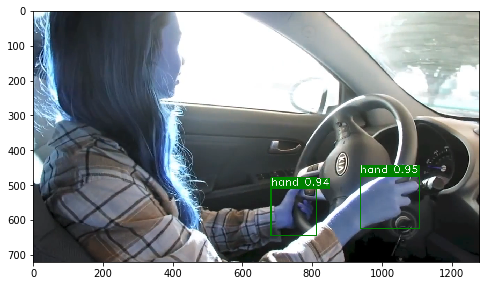

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import paddlex as pdx

model = pdx.load_model('output/ppyolo_r50vd_dcn/best_model')
image_name = 'pos/15_0000543_0_0_0_0.png'
result = model.predict(image_name)
pdx.det.visualize(image_name, result, threshold=0.5, save_dir='./output/yolov3_darknet53')
visualize_name = 'visualize_' + image_name[4:]
img_path = os.path.join('output/yolov3_darknet53/', visualize_name)
plt.figure(figsize=(8, 8))
img = cv2.imread(img_path)
plt.imshow(img)


```
```

```
```请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 